# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
dataframe = pd.read_csv('/datasets/faces/labels.csv')
display(dataframe.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
dataframe.shape

(7591, 2)

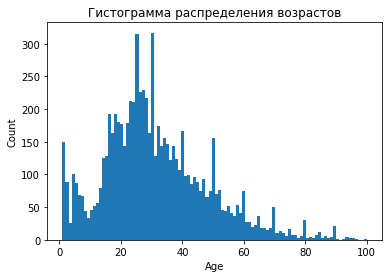

In [5]:
plt.hist(dataframe['real_age'], bins=100);
plt.title('Гистограмма распределения возрастов');
plt.xlabel('Age');
plt.ylabel('Count');

In [20]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


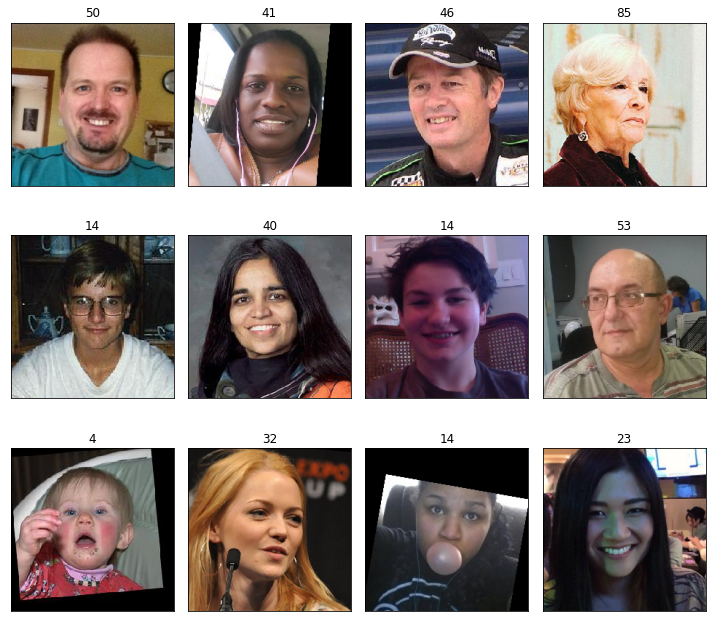

In [21]:
x, y = next(gen_flow)
fig = plt.figure(figsize = (10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Размер датасета (7591, 2).

Больше всего фотографий людей в возрасте от 20 до 30 лет. Датасет с фотографиями людей от 1 года до 100 лет.

На фотографиях мы видим, что все люди улыбаются.

Рекомендованные аугментации: повороты и сдвиги.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip=True, rescale=1. / 255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    test_gen_flow = test_data
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_gen_flow)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

# Вывод на экран

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10

178/178 - 47s - loss: 807.8187 - mae: 23.9147 - val_loss: 1141.0742 - val_mae: 29.3326
Epoch 2/10
178/178 - 39s - loss: 208.5072 - mae: 11.0564 - val_loss: 1135.7718 - val_mae: 29.2361
Epoch 3/10
178/178 - 40s - loss: 99.7414 - mae: 7.4620 - val_loss: 926.3961 - val_mae: 25.6449
Epoch 4/10
178/178 - 40s - loss: 64.1336 - mae: 6.0462 - val_loss: 188.1246 - val_mae: 10.1781
Epoch 5/10
178/178 - 41s - loss: 46.9928 - mae: 5.2065 - val_loss: 102.9592 - val_mae: 7.6465
Epoch 6/10
178/178 - 51s - loss: 34.9985 - mae: 4.5310 - val_loss: 89.5588 - val_mae: 7.2404
Epoch 7/10
178/178 - 50s - loss: 27.5958 - mae: 4.0267 - val_loss: 84.5213 - val_mae: 6.9282
Epoch 8/10
178/178 - 42s - loss: 22.1549 - mae: 3.6097 - val_loss: 86.3828 - val_mae: 6.8986
Epoch 9/10
178/178 - 53s - loss: 19.1567 - mae: 3.3824 - val_loss: 84.6903 - val_mae: 6.8765
Epoch 10/10
178/178 - 51s - loss: 16.5826 - mae: 3.1404 - val_loss: 84.0651 - val_mae: 6.8807

60/60 - 10s - loss: 84.0651 - mae: 6.8807
Test MAE: 6.8807

```

## Анализ обученной модели

Я построила и обучила свёрточную нейронную сеть на датасете с фотографиями людей и добилась значения MAE на тестовой выборке 6.88, что является хорошим результатом.

Использованная архитектура: бэкбон без головы, загружались предобученные веса.

Размер батча = 32, оптимизатор Адам, заморозка не использовалась, 10 эпох.

Переобучение на 10й эпохе.